svi - decoder for continuous y:
    
the key is to represent important quantities as random variables, and then sample from them:
    
$s \sim \mathcal{N}(\cdot, \cdot)$,

$z \sim \text{Categorical}(\pi)$,

$\pi = \lambda / \sum \lambda$,

$\log(\lambda) \sim \mathcal{N}(b + \beta y, 0)$,

$y \sim \mathcal{GP}(\cdot, \cdot)$

(remember to specify the priors for these R.V.s)

when calculate the elbo, we can sample from these R.V.s and then use `pytorch`'s existing functionality to compute the log-likelihood and differential entropy terms.

**caveat**: since a finite subset of GP is just a multivariate normal, we can set its mean and kernel function as parameters to be learned by SGD, and then do everything else w.r.t. the multivariate normal. (see [gaussian-process-tutorial](https://peterroelants.github.io/posts/gaussian-process-tutorial/))

we can still keep the cavi encoder but implement a svi decoder. the principle is that if we can get exact estimates (cavi) then exact is prefered over stochastic (svi).

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge
from sklearn.mixture import GaussianMixture
from sklearn.metrics import r2_score

import torch
import torch.distributions as D

from clusterless import preprocess
from clusterless import decoder

In [2]:
seed = 666
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.set_default_dtype(torch.double)

In [3]:
SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 25

plt.rc('font', size=MEDIUM_SIZE)         
plt.rc('axes', titlesize=MEDIUM_SIZE)     
plt.rc('axes', labelsize=MEDIUM_SIZE) 
plt.rc('axes', linewidth = 1.5)
plt.rc('xtick', labelsize=MEDIUM_SIZE)   
plt.rc('ytick', labelsize=MEDIUM_SIZE)   
plt.rc('legend', fontsize=MEDIUM_SIZE)   
plt.rc('figure', titlesize=MEDIUM_SIZE)

#### data

In [4]:
pid = 'dab512bd-a02d-4c1f-8dbc-9155a163efc0'
rootpath = '/mnt/3TB/yizi/Downloads/ONE/openalyx.internationalbrainlab.org'
trial_data_path = rootpath + '/danlab/Subjects/DY_016/2020-09-12/001/alf'
neural_data_path = '/mnt/3TB/yizi/danlab/Subjects/DY_016'
behavior_data_path = rootpath + '/paper_repro_ephys_data/figure9_10/original_data'
save_path = '../saved_results/danlab/Subjects/DY_016/cavi_results/continuous/'

In [5]:
unsorted_trials, stim_on_times, np1_channel_map = preprocess.load_neural_data(
    pid=pid, 
    trial_data_path=trial_data_path,
    neural_data_path=neural_data_path,
    behavior_data_path=behavior_data_path,
    keep_active_trials=True, 
    roi='all',
    kilosort=False,
    triage=False
)

behave_dict = preprocess.load_behaviors_data(behavior_data_path, pid)
_, wheel_velocity, _, _, _, _ = preprocess.preprocess_dynamic_behaviors(behave_dict)

pid: dab512bd-a02d-4c1f-8dbc-9155a163efc0
eid: d23a44ef-1402-4ed7-97f5-47e9a7a504d9
1st trial stim on time: 17.56, last trial stim on time 2310.24


In [6]:
class DataLoader():
    def __init__(self, data, y, stim_on_times, np1_channel_map, n_t_bins=30):
        self.data = data
        self.y = y
        self.stim_on_times = stim_on_times
        self.np1_channel_map = np1_channel_map
        self.n_t_bins = n_t_bins
        self.n_trials = stim_on_times.shape[0]
        self.n_channels = np1_channel_map.shape[0]
        self.t_binning = np.arange(0, 1.5, step = (1.5 - 0) / n_t_bins)
        self.rand_trial_ids = np.arange(self.n_trials)
        
        # allocate unsorted data into trials
        self.trial_ids = []
        self.t_ids = []
        self.trials = []
        self.t_bins = []
        for k in range(self.n_trials):
            mask = np.logical_and(data[:,0] >= stim_on_times[k] - 0.5,
                                  data[:,0] <= stim_on_times[k] + 1)
            trial = data[mask,:]
            trial[:,0] = trial[:,0] - trial[:,0].min()
            t_bins = np.digitize(trial[:,0], self.t_binning, right = False) - 1
            t_bin_lst = []
            for t in range(self.n_t_bins):
                t_bin = trial[t_bins == t,1:]
                self.trial_ids.append(np.ones_like(t_bin[:,0]) * k)
                self.t_ids.append(np.ones_like(t_bin[:,0]) * t)
                t_bin_lst.append(t_bin)
            self.trials.append(t_bin_lst)
    
    
    def split_train_test(self, split=.8):
        
        self.train_ids = self.rand_trial_ids[:int(split * self.n_trials)]
        self.test_ids = self.rand_trial_ids[int(split * self.n_trials):]
        self.y_train = self.y[self.train_ids]
        self.y_test = self.y[self.test_ids]
        
        trial_ids = np.concatenate(self.trial_ids)
        t_ids = np.concatenate(self.t_ids)
        trials = np.concatenate(np.concatenate(self.trials))

        train_mask = np.sum([trial_ids == idx for idx in self.train_ids], axis=0).astype(bool)
        test_mask = np.sum([trial_ids == idx for idx in self.test_ids], axis=0).astype(bool)
        train_k_ids, test_k_ids = trial_ids[train_mask], trial_ids[test_mask]
        train_t_ids, test_t_ids = t_ids[train_mask], t_ids[test_mask]
        train_trials, test_trials = trials[train_mask], trials[test_mask]
        
        return train_trials, train_k_ids, train_t_ids, \
               test_trials, test_k_ids, test_t_ids

In [7]:
data_loader = DataLoader(data = np.concatenate(unsorted_trials)[:,[0,2,3,4]], 
                         y = wheel_velocity, 
                         stim_on_times = stim_on_times, 
                         np1_channel_map = np1_channel_map, 
                         n_t_bins=30)

In [8]:
train_trials, train_k_ids, train_t_ids, test_trials, test_k_ids, test_t_ids = \
    data_loader.split_train_test(split=.98)

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [9]:
gmm = GaussianMixture(n_components=10, 
                      covariance_type='full', 
                      init_params='k-means++',
                      verbose=0)
gmm.fit(train_trials)

GaussianMixture(init_params='k-means++', n_components=10)

In [9]:
s = torch.tensor(test_trials)
y = torch.tensor(data_loader.y_test)

Nk = len(data_loader.test_ids)
Nt = data_loader.n_t_bins
Nc = 10
Nd = s.shape[1]

#### decoder

In [10]:
def safe_log(x, minval=1e-10):
    return torch.log(x + minval)

In [24]:
class SVI(torch.nn.Module):

    def __init__(self, 
                 Nk, Nt, Nc, Nd, 
                 init_means, init_covs, init_ys,
                 init_bs, init_betas,
                 ks, ts):
        super(SVI, self).__init__()
        self.Nk = Nk
        self.Nt = Nt
        self.Nc = Nc
        self.Nd = Nd
        self.ks = ks
        self.ts = ts
        
        # initialize parameters for variational distribution
        self.means = torch.nn.Parameter(init_means, requires_grad=False)
        self.covs = torch.nn.Parameter(init_covs, requires_grad=False)
        self.bs = torch.nn.Parameter(init_bs, requires_grad=False)
        self.betas = torch.nn.Parameter(init_betas, requires_grad=False)
        
        # latent y
        self.yhat = torch.nn.Parameter(torch.randn((Nk, Nt)), requires_grad=True)
        # self.yhat = torch.nn.Parameter(torch.ones((Nk, Nt)) * torch.tensor(init_ys), requires_grad=True)
        
        
    def forward(self, s, M=100):
        
        # compute log(lambda_kjt)
        log_lambdas = torch.zeros((self.Nk, self.Nc, self.Nt))
        for k in range(self.Nk):
            for t in range(self.Nt):
                log_lambdas[k,:,t] = self.bs + self.betas[:,t] @ self.yhat[k]
        
        # compute log(pi_kjt)
        self.log_pis = log_lambdas - torch.logsumexp(log_lambdas, 1)[:,None,:]
        
        
        # compute log-likelihood
        ll = torch.zeros((s.shape[0], self.Nc))
        for j in range(self.Nc):
            ll[:,j] = D.multivariate_normal.MultivariateNormal(
                            loc=self.means[j], 
                            covariance_matrix=self.covs[j]
                        ).log_prob(s)
        
        
        # compute exact update for q(z)
        q_z = torch.zeros((s.shape[0], self.Nc))
        for k in range(self.Nk):
            for t in range(self.Nt):
                k_t_idx = torch.logical_and(self.ks == torch.unique(self.ks)[k], self.ts == t)
                q_z[k_t_idx] = torch.exp( ll[k_t_idx] + self.log_pis[k,:,t] )
                q_z[k_t_idx] = q_z[k_t_idx] / q_z[k_t_idx].sum(1)[:,None]
        
        
        # compute ELBO = E_z,y[logp(s,z,y)] - E_z,y[logq(z,y)]
        # E_z,y[logp(s,z,y)] = E_z,y[logp(s|z) + logp(z|y) + logp(y)]
        
        E_q_log_p_s_cond_z = 0
        E_q_log_p_z_cond_y = 0
        H_z = 0
        for k in range(Nk):
            for t in range(Nt):
                k_t_idx = torch.logical_and(self.ks == torch.unique(self.ks)[k], self.ts == t)
                E_q_log_p_s_cond_z += torch.sum( q_z[k_t_idx] * ll[k_t_idx] )
                E_q_log_p_z_cond_y += torch.sum( q_z[k_t_idx] * self.log_pis[k,:,t] )
                H_z -= torch.sum( q_z[k_t_idx] * safe_log(q_z[k_t_idx]) )
                
                
        # print(f'E_q(z)[logp(s|z)] = {E_q_log_p_s_cond_z}')
        # print(f'E_q(z)[logp(z|y)] = {E_q_log_p_z_cond_y}')
        # print(f'E_q(z)[logq(z)] = {H_z}')
        
        return E_q_log_p_s_cond_z + E_q_log_p_z_cond_y + H_z

In [38]:
enc = np.load('../saved_results/danlab/Subjects/DY_016/cavi_results/' + f'cont_y_enc_res_c{Nc}.npy', allow_pickle=True).item()

In [39]:
svi = SVI(Nk, Nt, Nc, Nd, 
          enc['means'].requires_grad_(False), 
          enc['covs'].requires_grad_(False), 
          data_loader.y_train.mean(0),
          enc['bs'].requires_grad_(False),
          enc['betas'].requires_grad_(False),
          torch.tensor(test_k_ids), 
          torch.tensor(test_t_ids)
         )
optim = torch.optim.Adam(svi.parameters(), lr=1e-1)

In [40]:
%%time
max_iter = 200
elbos = []
for i in range(max_iter):
    elbo = svi(s, M=1000)
    loss = - elbo 
    print(f'iter: {i+1} elbo: {elbo:.2f}')
    elbos.append(elbo)
    optim.zero_grad()
    loss.backward()
    optim.step()

iter: 1 elbo: -414067.93
iter: 2 elbo: -395231.50
iter: 3 elbo: -377531.74
iter: 4 elbo: -361266.33
iter: 5 elbo: -346287.28
iter: 6 elbo: -333207.97
iter: 7 elbo: -322491.81
iter: 8 elbo: -313455.96
iter: 9 elbo: -305442.37
iter: 10 elbo: -298383.80
iter: 11 elbo: -292316.05
iter: 12 elbo: -287050.01
iter: 13 elbo: -282512.49
iter: 14 elbo: -278632.59
iter: 15 elbo: -275179.42
iter: 16 elbo: -272161.75
iter: 17 elbo: -269618.15
iter: 18 elbo: -267453.75
iter: 19 elbo: -265573.88
iter: 20 elbo: -263898.11
iter: 21 elbo: -262288.70
iter: 22 elbo: -260645.36
iter: 23 elbo: -258984.91
iter: 24 elbo: -257428.24
iter: 25 elbo: -256049.60
iter: 26 elbo: -254818.19
iter: 27 elbo: -253650.01
iter: 28 elbo: -252409.06
iter: 29 elbo: -251081.18
iter: 30 elbo: -249829.88
iter: 31 elbo: -248833.69
iter: 32 elbo: -248120.96
iter: 33 elbo: -247579.74
iter: 34 elbo: -247145.45
iter: 35 elbo: -246851.18
iter: 36 elbo: -246687.57
iter: 37 elbo: -246524.84
iter: 38 elbo: -246227.61
iter: 39 elbo: -24577

In [41]:
elbos = [elbo.detach().numpy() for elbo in elbos]

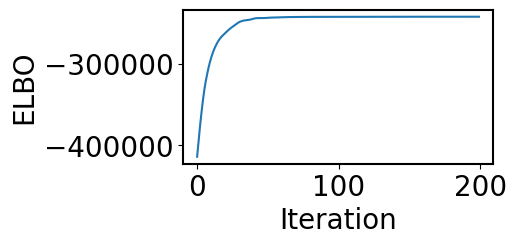

In [42]:
plt.figure(figsize=(4,2))
plt.plot(elbos)
plt.xlabel("Iteration")
plt.ylabel("ELBO");

In [48]:
y_true = np.hstack(y)
y_pred = np.hstack([svi.yhat[k].detach().numpy() for k in range(len(data_loader.test_ids))])
r2_score(y_true, y_pred)

0.05677407672582069

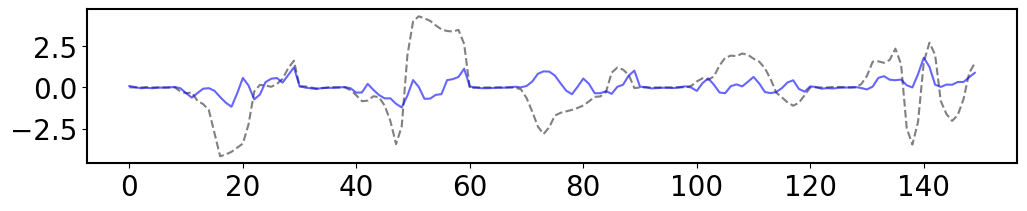

In [49]:
plt.figure(figsize=(12, 2))
plt.plot(y_true[:150], c='gray', linestyle='dashed', label='observed');
plt.plot(y_pred[:150], c='blue', alpha=.6, label='predicted');

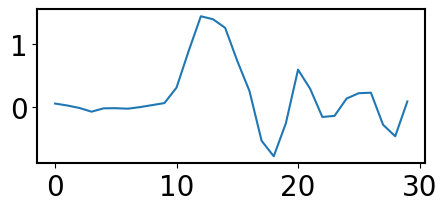

In [55]:
i = -1
plt.figure(figsize=(5,2))
plt.plot(svi.yhat[i].detach().numpy());

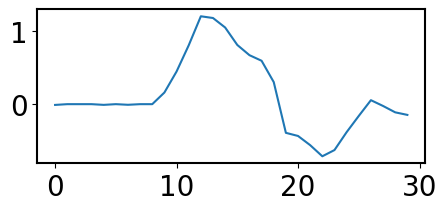

In [56]:
plt.figure(figsize=(5,2))
plt.plot(y[i]);

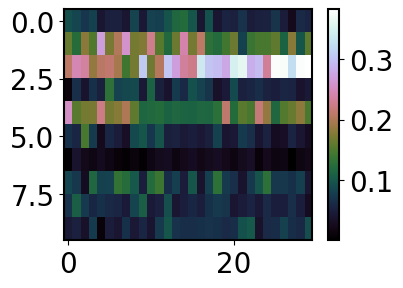

In [47]:
plt.figure(figsize=(4,3))
plt.imshow(torch.exp(svi.log_pis[i]).detach().numpy(), 
           aspect='auto', cmap='cubehelix')
plt.colorbar();